<a href="https://colab.research.google.com/github/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/01_linear_regression_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial intelligence in a nutshell

In this notebook, we will talk about
* What is AI training?
* How does large language model work?
* A simple AI model: linear regression

**How to run this notebook on Polaris**
* Go to https://jupyter.alcf.anl.gov, and click "Login Polaris"
* After login, select ALCFAITP project
* Load the notebook and select "datascience/conda-2023-01-10" python kernel

<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/jupyter1.png?raw=1" width="600" />
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/jupyter2.png?raw=1" width="600" />
</p>

**How to run this notebook on Google Colab**

* Go to https://colab.research.google.com/, sign in or sign up
* "File"-> "open notebook"
* choose ```01_intro_AI_on_Supercomputer/01_linear_regression_sgd.ipynb``` from the list
![Google Colab](https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/colab.png?raw=1)

## What is AI training?
**Two ways of learning English**
* through learning rules;
* through hearing a lot of speakings
<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/data_driven.png?raw=1" width="1000" />
</p>

I learned English in my middle school, and memorized a lot of grammar rules in my mind. Every time when I speak, I try to follow the grammar rules as much as I can. But I always break the rules.

However, my daugher Phoebe learned English differently. She learns speaking by hearing a lot of speaking from TV, teachers, classmates, and her older brother Nehemiah. The fact is that, she seldomly breaks grammar rules. This way of learning by observing patterns is very powerful! This is the essence of AI or data driven science.

## How does large language model work?

Large Language Models, like GPT, function by pre-training on extensive datasets to learn language patterns, utilizing transformer architecture for contextual understanding, and can be fine-tuned for specific tasks, enabling them to generate coherent and contextually relevant text based on provided inputs.

<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/LLM.png?raw=1" width="600" />
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/chatgpt_response.png?raw=1" width="160" />
</p>

**More complicated example**

<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/chatgpt_poem.png?raw=1" width="450" />
</p>

You can do this on https://chat.openai.com

## Simplest AI model example: linear regression
This example is adopted from Bethany Lusch, ALCF.

Linear regression is the simplest example ``learning" from existing data for future prediction.
<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/excel_linear_regression.jpg?raw=1" width="400" />
</p>

We're going to review the math involved in this process to help understand how training an AI works.

First we will load some tools that others wrote and we can use to help us work.
* [Pandas](https://pandas.pydata.org/docs/): a toolkit for working with row vs. column data, like excel sheets, and CSV (Comma Seperated Values) files.
* [Numpy](https://numpy.org/doc/): a toolkit for managing arrays, vectors, matrices, etc, doing math with them, slicing them up, and many other handy things.
* [Matplotlib](https://matplotlib.org/stable/index.html): a toolkit for plotting data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipydis
import time

### Dataset
We used a realestate dataset from Kaggle to produce this reduced dataset. This dataset contains the _sale price_ and _above ground square feet_ of many houses. We can use this data for our linear regression.

We use Pandas to read the data file which is stored as Comma Separated Values (CSV). and print the column labels. CSV files are similar to excel sheets.

In [3]:
! [ -e ./slimmed_realestate_data.csv ] || wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/slimmed_realestate_data.csv
data = pd.read_csv('slimmed_realestate_data.csv')
print(data.columns)
print(data.head())

Index(['Unnamed: 0', 'SalePrice', 'GrLivArea'], dtype='object')
   Unnamed: 0  SalePrice  GrLivArea
0           1     181500       1262
1           7     200000       2090
2           9     118000       1077
3          12     144000        912
4          15     132000        854


Now pandas provides some helpful tools for us to inspect our data. It provides a `plot()` function that, behind the scenes, is calling into the _Matplotlib_ library and calling the function [matplotlib.pyplot.plot()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). In this case, we simply tell it the names of the columns we want as our _x_ and _y_ values and the `style` (`'.'` tells `matplotlib` to use a small dot to represent each data point).

<Axes: xlabel='GrLivArea'>

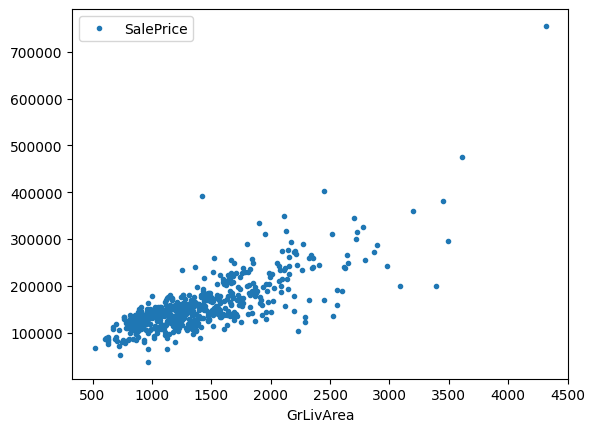

In [4]:
data.plot(x='GrLivArea', y='SalePrice',style='.')

### Theory of linear regression

The goal of learning regression is to find a line that is closest to all the points.

The slope and intercept of such a line $y = m x + b$ can be found as:

They are:

$$m = { n (\Sigma xy) - (\Sigma x) (\Sigma y) \over n (\Sigma x^2) - (\Sigma x)^2 } $$

$$b = { (\Sigma y) (\Sigma x^2) - (\Sigma x) (\Sigma xy) \over n (\Sigma x^2) - (\Sigma x)^2 } $$

Details derivation of this can be found [here](https://en.wikipedia.org/wiki/Simple_linear_regression).

We'll break this calculation into a few steps to help make it easier.

First lets define $x$ and $y$. $x$ will be our _above ground square footage_ and $y$ will be _sale price_. In our equations we have a few different values we need, such as $n$ which is just the number of points we have:

In [5]:
n = len(data)

Then we need our $x$ and $y$ by selecting only the column we care about for each one. Note about data formats: `data` is a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame) object which has rows and columns; `data['GrLivArea']` is a Pandas [Series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) object which only has rows; then we also convert from _Pandas_ data formats (in this case a _Series_) to _Numpy_ data formats using the `to_numpy()` function which is part of the Pandas _Series_ object.

In [6]:
x = data['GrLivArea'].to_numpy()
y = data['SalePrice'].to_numpy()

Now we will calculate $\Sigma xy$, $\Sigma x$, $\Sigma y$, and $\Sigma x^2$:

In [7]:
sum_xy = np.sum(x*y)
sum_x  = np.sum(x)
sum_y  = np.sum(y)
sum_x2 = np.sum(x*x)

The denominator in the equation for $m$ and $b$ are the same so we can calculate that once:

In [8]:
denominator = n * sum_x2 - sum_x * sum_x
print(denominator)

83388038314


Then we can calculate our fit values:

In [9]:
m = (n * sum_xy - sum_x * sum_y) / denominator
b = (sum_y * sum_x2 - sum_x * sum_xy) / denominator
print('y = %f * x + %f' % (m,b))

# saving these for later comparison
m_calc = m
b_calc = b

y = 87.688145 * x + 34754.077892


Now we can plot the fit results with our data to see how we did.

First we define a plotting function because we're going to do this often and we want to reuse our code:

In [10]:
def plot_data(x,y,m,b,plt = plt):
   # plot our data points with 'bo' = blue circles
   plt.plot(x,y,'bo')
   # create the line based on our linear fit
   # first we need to make x points
   # the 'arange' function generates points between two limits (min,max)
   linear_x = np.arange(x.min(),x.max())
   # now we use our fit parameters to calculate the y points based on our x points
   linear_y = linear_x * m + b
   # plot the linear points using 'r-' = red line
   plt.plot(linear_x,linear_y,'r-',label='fit')
   plt.xlabel("square footage")
   plt.ylabel("sale price")

Now can use this function to plot our results:

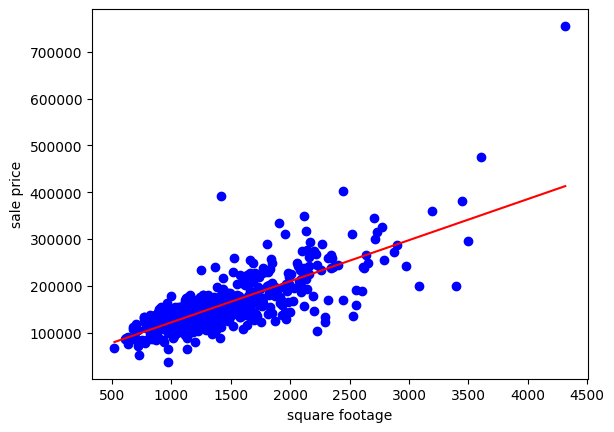

In [11]:
plot_data(x,y,m,b)

### Training through Stochastic Gradient Descent (SGD)

SGD is a common method in AI for training deep neural networks on large datasets. It is an iterative method for optimizing a loss function that we get to define. We will use this simple linear regression to demonstrate how it works.

#### The model

In AI, neural networks are often referred to as a _model_ because, once fully trained, they should model (AKA predict) the behavior of our system. In our example, the system is how house prices vary based on house size. We know our system is roughly driven by a linear function:

$$ \hat{y_i}(x_i) = m * x_i + b $$

We just need to figure out $m$ and $b$. Let's create a function that calculates our model given $x$, $m$, and $b$.


In [12]:
def model(x,m,b):
   return m * x + b


#### The Loss Function

A _loss function_, or _objective function_, is something we define and is based on what we want to achieve. In the method of SGD, it is our goal to minimize (or make close to zero) the values calculated from the _loss function_. In our example, we ideally want the prediction of our _model_ to be equal to the actual data, though we will settle for "as close as possible".

So we will select our _loss function_ to be the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) function:

$$ L(y_i,\hat{y_i}) = (y_i - \hat{y_i}(x_i))^2 $$

where $y_i$ is our $i^{th}$ entry in the `data['SalePrice']` vector and $\hat{y_i}$ is the prediction based on evaluting $m * x_i + b$.

This function looks like the figure below when we plot it with $x=y_i - \hat{y_i}(x_i)$ and we we want to be down near $y_i - \hat{y_i}(x_i) = 0$ which indicates that our $y_i$ is as close as possible to $\hat{y_i}$.

<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/loss_func.png?raw=1" width="400" />
</p>

Here we crate a function that calculates this for us.

In [13]:
def loss(x,y,m,b):
   y_predicted = model(x,m,b)
   return np.power( y - y_predicted, 2 )

#### Minimizing the Loss Function

We want to use the loss function in order to guide how to update $m$ and $b$ to better model our system. In calculus we learn to minimize a function with respect to a variable you calculate the _partial derivative_ with respect to the variable you want to vary.

$$ { \partial L \over \partial m } = 0 $$

The location of the solution to this is the minimum as shown in the figure above. We can write down the partial derivative of the loss function as:

$$ { \partial L \over \partial m } = -2 x_i (y_i - \hat{y_i}(x_i)) $$
$$ { \partial L \over \partial b } = -2 (y_i - \hat{y_i}(x_i)) $$

We can use this to calculate an adjustment to $m$ and $b$ that will reduce the loss function, effectively improving our fitting parameters. This is done using this equation:

$$ m' = m - \eta { \partial L \over \partial m }$$
$$ b' = b - \eta { \partial L \over \partial b }$$

Here our original $m$ and $b$ are adjusted by the partial derivative multiplied by some small factor, $\eta$, called the _learning rate_. This learning rate is very important in our process and must be tuned for every problem.

In our example, the selection of the learning rate essentially defines how close we can get to the minimum, AKA the best fit solution. This figure shows what happens when we pick a large learning rate. We first select a starting point in our loss function (typically randomly), then every update from $m$/$b$ to $m'$/$b'$ results in a shift to somewhere else on our loss function (following the red arrows). In this example, our learning rate ($\eta$) has been selected too large such that we bounce back and forth around the minimum, never reaching it.

<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/parabola_largeLR.png?raw=1" width="400" />
</p>

If we select a smaller learning we can see better behavior in the next figure.

<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/parabola_smallLR.png?raw=1" width="400" />
</p>

Though, keep in mind, too small a learning rate results is so little progress toward the minimum that you may never reach it!

A pit fall of SGD that one must be aware of is when your loss function is complex, with many minima. The next figure shows such a case, in which we select a small learning rate and our starting point happens to be near a local minimum that is not the lowest minimum. As shown, we do reach a minimum, but it isn't the lowest minimum in our loss function. It could be that we randomly select a starting point near the minimum we care about, but we should build methods that are more robust against randomly getting the right answer.

<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/local_min_smallLR.png?raw=1" width="400" />
</p>

Then, if we increase our learning rate too much, we bounce around again.

<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/local_min_largeLR.png?raw=1" width="400" />
</p>

What we want to do in this situation is start with a large learning rate and slowly reduce its size as we progress. That is shown in this next figure.

<p float="center">
  <img src="https://github.com/robmariv/ai-science-training-series/blob/main/01_intro_AI_on_Supercomputer/figures/local_min_variableLR.png?raw=1" width="400" />
</p>

As you can see, this process is not perfect and could still land in a local minimum, but it is important to be aware of these behaviors as you utilize SGD in machine learning.

So let's continue, we'll build functions we can use to update our fit parameters, $m$ and $b$.

In [14]:
def updated_m(x,y,m,b,learning_rate):
   dL_dm = - 2 * x * (y - model(x,m,b))
   dL_dm = np.mean(dL_dm)
   return m - learning_rate * dL_dm

def updated_b(x,y,m,b,learning_rate):
   dL_db = - 2 * (y - model(x,m,b))
   dL_db = np.mean(dL_db)
   return b - learning_rate * dL_db

# Putting it together

We can now randomly select our initial slope and intercept:

In [15]:
m = 5.
b = 1000.
print('y_i = %.2f * x + %.2f' % (m,b))

y_i = 5.00 * x + 1000.00


Then we can calculate our Loss function:

In [16]:
l = loss(x,y,m,b)
print('first 10 loss values: ',l[:10])

first 10 loss values:  [3.03421561e+10 3.55511025e+10 1.24579082e+10 1.91656336e+10
 1.60604929e+10 2.04432804e+10 1.72410030e+10 1.76517796e+10
 1.52769600e+10 2.18152900e+10]


y_i = 5.47 * x + 1000.00     previously calculated: y_i = 87.69 * x + 34754.08


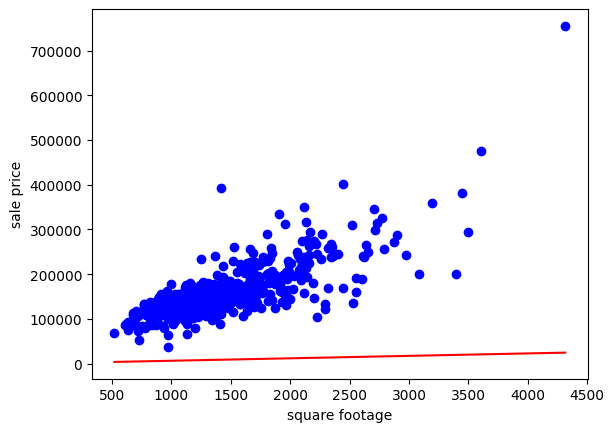

In [17]:
learning_rate = 1e-9
m = updated_m(x,y,m,b,learning_rate)
b = updated_b(x,y,m,b,learning_rate)
print('y_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f' % (m,b,m_calc,b_calc))
plot_data(x,y,m,b)

[005]  dy_i = 88.95 * x + 31525.71     previously calculated: y_i = 87.69 * x + 34754.08    loss: 1480323913.049650


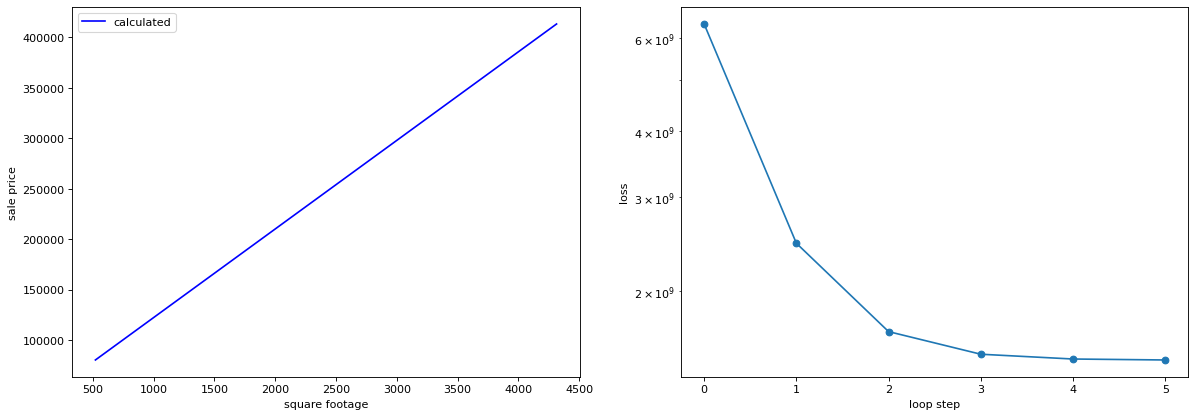

KeyboardInterrupt: 

In [18]:
# set our initial slope and intercept
m = 5.
b = 1000.
# batch_size = 60
# set a learning rate for each parameter
learning_rate_m = 1e-7
learning_rate_b = 1e-1
# use these to plot our progress over time
loss_history = []
# convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
data_x = data['GrLivArea'].to_numpy()
data_y = data['SalePrice'].to_numpy()
print('data_x', data_x)
print('data_y', data_y)
# we run our loop N times
loop_N = 30
for i in range(loop_N):
   # update our slope and intercept based on the current values
   m = updated_m(data_x,data_y,m,b,learning_rate_m)
   b = updated_b(data_x,data_y,m,b,learning_rate_b)

   # calculate the loss value
   loss_value = np.mean(loss(data_x,data_y,m,b))

   # keep a history of our loss values
   loss_history.append(loss_value)

   # print our progress
   print('[%03d]  dy_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f    loss: %f' % (i,m,b,m_calc,b_calc,loss_value))

   # close/delete previous plots
   plt.close('all')

   # create a 1 by 2 plot grid
   fig,ax = plt.subplots(1,2,figsize=(18,6),dpi=80)
   # lot our usual output
   #plot_data(data_x,data_y,m,b,ax[0])

   # here we also plot the calculated linear fit for comparison
   line_x = np.arange(data_x.min(),data_x.max())
   line_y = line_x * m_calc + b_calc
   ax[0].plot(line_x,line_y,'b-',label='calculated')
   # add a legend to the plot and x/y labels
   ax[0].legend()
   ax[0].set_xlabel('square footage')
   ax[0].set_ylabel('sale price')

   # plot the loss
   loss_x = np.arange(0,len(loss_history))
   loss_y = np.asarray(loss_history)
   ax[1].plot(loss_x,loss_y, 'o-')
   ax[1].set_yscale('log')
   ax[1].set_xlabel('loop step')
   ax[1].set_ylabel('loss')
   plt.show()
   # gives us time to see the plot
   time.sleep(2.5)
   # clears the plot when the next plot is ready to show.
   ipydis.clear_output(wait=True)



# Homework
## Mini Batch Training
In AI, datasets are often very large and cannot be processed all at once as is done in the loop above. The data is instead randomly sampled in smaller _batches_ where each _batch_ contains `batch_size` inputs. How can you change the loop above to sample the dataset in smaller batches? Hint: Our `data` variable is a Pandas `DataFrame` object, search for "how to sample a DataFrame".

Instead of using the entire dataset like
```python
data_x = data['GrLivArea'].to_numpy()
data_y = data['SalePrice'].to_numpy()
```
Use
```python
data_batch = data.sample(batch_size)
data_x = data_batch['GrLivArea'].to_numpy()
data_y = data_batch['SalePrice'].to_numpy()
```

You also have to adjust the loop_N accordingly to make sure that it loop over the entire datasets the same number of times.
```python
loop_N = 30*(data['GrLivArea'].shape)//batch_size
```

Please plot your learning curve for different batch size, such as 64, 256, 1024, 4096.

## Learning rate issue (Bonus)
As described above, if the learning rate is too large, it will affect the convergence. Do your training with (batch_size = 64, learning_rate_m = 1e-7, learning_rate_b = 1e-1). Then linearly increase the batch size and learning rate until you see the training does not converge.
```
(64, 1e-7, 1e-1)*4
(64, 1e-7, 1e-1)*16
(64, 1e-7, 1e-1)*32
...
```

**How to submit your homework**
* Fork the github repo to your personal github
* Make change to the 01_linear_regression_sgd.ipynb, and then push to your personal github
* Provide the link of 01_linear_regression_sgd in the personal github.

Follow the below instruction on how to do this:
https://github.com/argonne-lcf/ai-science-training-series/blob/main/00_introToAlcf/03_githubHomework.md

y = 87.688145 * x + 34754.077892
Index(['Unnamed: 0', 'SalePrice', 'GrLivArea'], dtype='object')
   Unnamed: 0  SalePrice  GrLivArea
0           1     181500       1262
1           7     200000       2090
2           9     118000       1077
3          12     144000        912
4          15     132000        854

i, batch 0 32
row,col 0 0
loss_history []
loop_N = 30*(data[GrLivArea].shape[0])//batch =  516
loop_N = 30*(len(data))//batch = 516
[515]  dy_i = 110.49 * x + -3709.69     previously calculated: y_i = 110.49 * x + -3709.69    loss: 1499394522.119801

i, batch 1 60
row,col 0 1
loss_history []
loop_N = 30*(data[GrLivArea].shape[0])//batch =  275
loop_N = 30*(len(data))//batch = 275
[274]  dy_i = 75.27 * x + 48992.92     previously calculated: y_i = 75.27 * x + 48992.92    loss: 1153734710.797070

i, batch 2 64
row,col 1 0
loss_history []
loop_N = 30*(data[GrLivArea].shape[0])//batch =  258
loop_N = 30*(len(data))//batch = 258
[257]  dy_i = 101.06 * x + 16496.18     previously cal

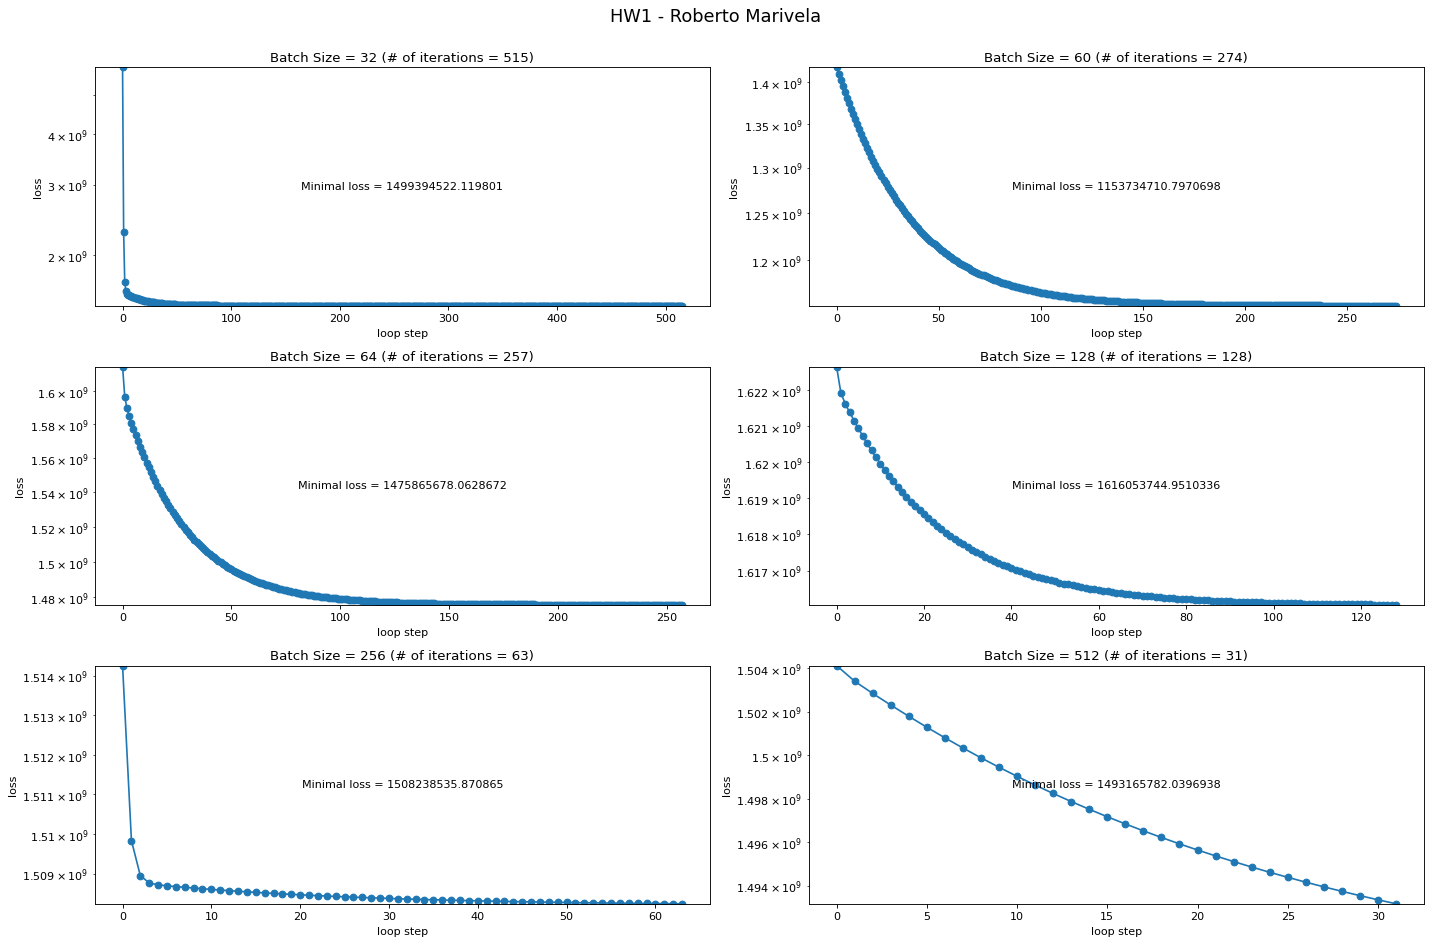

In [55]:
# HOMEWORK CELL - Roberto Marivela
# Bonus is in the next cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipydis
import time

! [ -e ./slimmed_realestate_data.csv ] || wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/slimmed_realestate_data.csv
data = pd.read_csv('slimmed_realestate_data.csv')

n = len(data)
x = data['GrLivArea'].to_numpy()
y = data['SalePrice'].to_numpy()
sum_xy = np.sum(x*y)
sum_x = np.sum(x)
sum_y = np.sum(y)
sum_x2 = np.sum(x*x)
denominator = n * sum_x2 - sum_x * sum_x
m = (n * sum_xy - sum_x * sum_y) / denominator
b = (sum_y * sum_x2 - sum_x * sum_xy) / denominator
print('y = %f * x + %f' % (m,b))

# saving these for later comparison
m_calc = m
b_calc = b

def model(x,m,b):
   return m * x + b

def loss(x,y,m,b):
   y_predicted = model(x,m,b)
   return np.power( y - y_predicted, 2 )

def updated_m(x,y,m,b,learning_rate):
   dL_dm = - 2 * x * (y - model(x,m,b))
   dL_dm = np.mean(dL_dm)
   return m - learning_rate * dL_dm

def updated_b(x,y,m,b,learning_rate):
   dL_db = - 2 * (y - model(x,m,b))
   dL_db = np.mean(dL_db)
   return b - learning_rate * dL_db

m = 5.
b = 1000.
batch_size = 60
# set a learning rate for each parameter
learning_rate_m = 1e-7
learning_rate_b = 1e-1
# use these to plot our progress over time
loss_history = []
# convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
  # data_x = data['GrLivArea'].to_numpy()   ## ORIGINAL
  # data_y = data['SalePrice'].to_numpy()   ## ORIGINAL

! [ -e ./slimmed_realestate_data.csv ] || wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/slimmed_realestate_data.csv
data = pd.read_csv('slimmed_realestate_data.csv')
print(data.columns)
print(data.head())

# data_batch = data.sample(batch_size)
# data_x = data_batch['GrLivArea'].to_numpy()
# data_y = data_batch['SalePrice'].to_numpy()

fig,ax  = plt.subplots(3,2,figsize=(18,12),dpi=80)
fig.suptitle('HW1 - Roberto Marivela\n', fontsize=16)
#batches = [64, 256, 1024, 4096]  # old
batches = [32, 60, 64, 128, 256, 512]
for i, batch in enumerate(batches):
  print('\ni, batch', i, batch)
  row = i // 2
  col = i  % 2
  print('row,col', row,col)

  data_batch = data.sample(batch)
  data_x = data_batch['GrLivArea'].to_numpy()
  data_y = data_batch['SalePrice'].to_numpy()

  loss_history = []
  print('loss_history', loss_history)
  loop_N = 30*(data['GrLivArea'].shape[0])//batch
  print('loop_N = 30*(data[GrLivArea].shape[0])//batch = ', loop_N)
  # loop_N = 30*(len(data))//batch
  print('loop_N = 30*(len(data))//batch =', loop_N)
  #loop_N = 4  # For testing
  for j in range(loop_N):
    # update our slope and intercept based on the current values
    m = updated_m(data_x,data_y,m,b,learning_rate_m)
    b = updated_b(data_x,data_y,m,b,learning_rate_b)

    # calculate the loss value
    loss_value = np.mean(loss(data_x,data_y,m,b))

    # keep a history of our loss values
    loss_history.append(loss_value)
    # close/delete previous plots
    # plt.close('all')

    # here we also plot the calculated linear fit for comparison
    line_x = np.arange(data_x.min(),data_x.max())
    line_y = line_x * m_calc + b_calc

  print('[%03d]  dy_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f    loss: %f' % (j,m,b,m,b,loss_value))
  # print('loss_history', loss_history)
  loss_x = np.arange(0,len(loss_history))
  loss_y = np.asarray(loss_history)
  ax[row, col].set_title('Batch Size = {0:d} (# of iterations = {1:d})'.format(batch, j))
  ax[row, col].plot(loss_x,loss_y, 'o-')
  ax[row, col].set_yscale('log')
  ax[row, col].set_xlabel('loop step')
  ax[row, col].set_ylabel('loss')
  ax[row, col].set_ylim(min(loss_history), max(loss_history))
  ax[row, col].text(0.5, 0.5, f'Minimal loss = {min(loss_history)}', horizontalalignment='center', verticalalignment='center', transform=ax[row, col].transAxes)

  # plt.show()
  # gives us time to see the plot
  time.sleep(2.5)
  # clears the plot when the next plot is ready to show.
  # ipydis.clear_output(wait=True)
plt.tight_layout()
plt.show()



y = 87.688145 * x + 34754.077892
Index(['Unnamed: 0', 'SalePrice', 'GrLivArea'], dtype='object')
   Unnamed: 0  SalePrice  GrLivArea
0           1     181500       1262
1           7     200000       2090
2           9     118000       1077
3          12     144000        912
4          15     132000        854

i, batch, inc 0 64 1
row,col 0 0
loop_N = 30*(data[GrLivArea].shape[0])//batch =  258
loop_N = 30*(len(data))//batch = 258
[257]  dy_i = 87.48 * x + 38527.35     previously calculated: y_i = 87.48 * x + 38527.35    loss: 1601614936.181552

i, batch, inc 1 128 2
row,col 0 1
loop_N = 30*(data[GrLivArea].shape[0])//batch =  129
loop_N = 30*(len(data))//batch = 129
[128]  dy_i = 103.55 * x + 10882.86     previously calculated: y_i = 103.55 * x + 10882.86    loss: 1906167790.513776

i, batch, inc 2 256 4
row,col 1 0
loop_N = 30*(data[GrLivArea].shape[0])//batch =  64
loop_N = 30*(len(data))//batch = 64
[063]  dy_i = 96.15 * x + 24165.88     previously calculated: y_i = 96.15 * x + 2

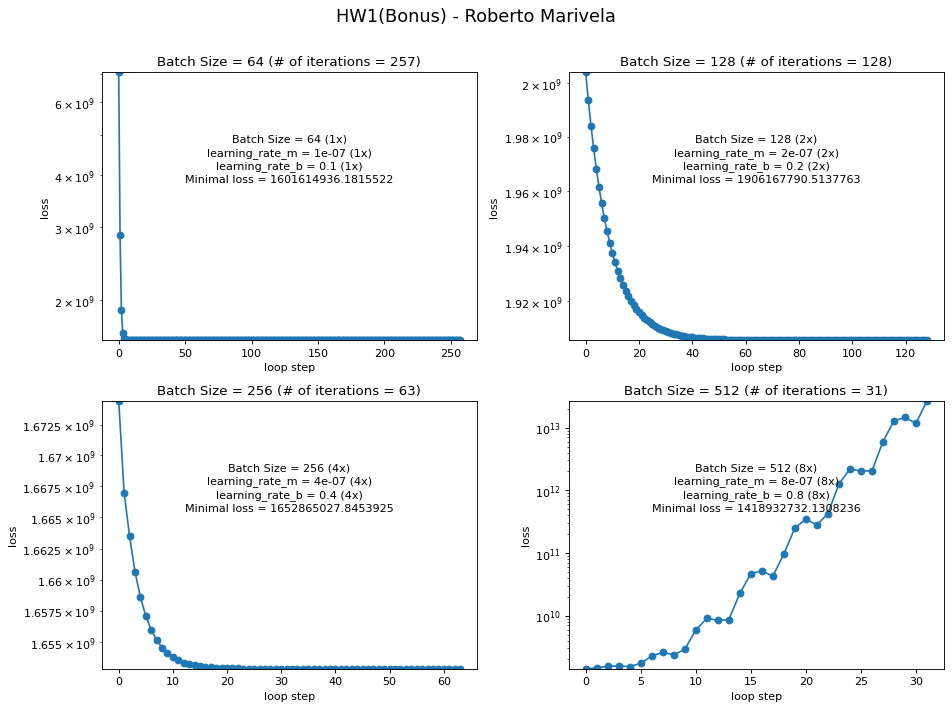

In [56]:
# Bonus CELL - Roberto Marivela
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipydis
import time

! [ -e ./slimmed_realestate_data.csv ] || wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/slimmed_realestate_data.csv
data = pd.read_csv('slimmed_realestate_data.csv')

n = len(data)
x = data['GrLivArea'].to_numpy()
y = data['SalePrice'].to_numpy()
sum_xy = np.sum(x*y)
sum_x = np.sum(x)
sum_y = np.sum(y)
sum_x2 = np.sum(x*x)
denominator = n * sum_x2 - sum_x * sum_x
m = (n * sum_xy - sum_x * sum_y) / denominator
b = (sum_y * sum_x2 - sum_x * sum_xy) / denominator
print('y = %f * x + %f' % (m,b))

# saving these for later comparison
m_calc = m
b_calc = b

def model(x,m,b):
   return m * x + b

def loss(x,y,m,b):
   y_predicted = model(x,m,b)
   return np.power( y - y_predicted, 2 )

def updated_m(x,y,m,b,learning_rate):
   dL_dm = - 2 * x * (y - model(x,m,b))
   dL_dm = np.mean(dL_dm)
   return m - learning_rate * dL_dm

def updated_b(x,y,m,b,learning_rate):
   dL_db = - 2 * (y - model(x,m,b))
   dL_db = np.mean(dL_db)
   return b - learning_rate * dL_db

m = 5.
b = 1000.
batch_size = 60
# set a learning rate for each parameter
learning_rate_m = 1e-7
learning_rate_b = 1e-1
# use these to plot our progress over time
loss_history = []
# convert panda data to numpy arrays, one for the "Ground Living Area" and one for "Sale Price"
  # data_x = data['GrLivArea'].to_numpy()   ## ORIGINAL
  # data_y = data['SalePrice'].to_numpy()   ## ORIGINAL

! [ -e ./slimmed_realestate_data.csv ] || wget https://raw.githubusercontent.com/argonne-lcf/ai-science-training-series/main/01_intro_AI_on_Supercomputer/slimmed_realestate_data.csv
data = pd.read_csv('slimmed_realestate_data.csv')
print(data.columns)
print(data.head())

# data_batch = data.sample(batch_size)
# data_x = data_batch['GrLivArea'].to_numpy()
# data_y = data_batch['SalePrice'].to_numpy()

fig,ax  = plt.subplots(2,2,figsize=(12,9),dpi=80)
fig.suptitle('HW1(Bonus) - Roberto Marivela\n', fontsize=16)
#batches = [64, 256, 1024, 4096]  # old
batch_ori = 64
increases = [1, 2, 4, 8]

for i, inc in enumerate(increases):
  batch           = 64   * inc
  learning_rate_m = 1e-7 * inc
  learning_rate_b = 1e-1 * inc
# for i, batch in enumerate(batches):
  print('\ni, batch, inc', i, batch, inc)
  row = i // 2
  col = i  % 2
  print('row,col', row,col)

  data_batch = data.sample(batch)
  data_x = data_batch['GrLivArea'].to_numpy()
  data_y = data_batch['SalePrice'].to_numpy()

  loss_history = []
  loop_N = 30*(data['GrLivArea'].shape[0])//batch
  print('loop_N = 30*(data[GrLivArea].shape[0])//batch = ', loop_N)
  # loop_N = 30*(len(data))//batch
  print('loop_N = 30*(len(data))//batch =', loop_N)
  #loop_N = 4  # For testing
  for j in range(loop_N):
    # update our slope and intercept based on the current values
    m = updated_m(data_x,data_y,m,b,learning_rate_m)
    b = updated_b(data_x,data_y,m,b,learning_rate_b)

    # calculate the loss value
    loss_value = np.mean(loss(data_x,data_y,m,b))

    # keep a history of our loss values
    loss_history.append(loss_value)
    # close/delete previous plots
    # plt.close('all')

    # here we also plot the calculated linear fit for comparison
    line_x = np.arange(data_x.min(),data_x.max())
    line_y = line_x * m_calc + b_calc

  print('[%03d]  dy_i = %.2f * x + %.2f     previously calculated: y_i = %.2f * x + %.2f    loss: %f' % (j,m,b,m,b,loss_value))
  # print('loss_history', loss_history)
  loss_x = np.arange(0,len(loss_history))
  loss_y = np.asarray(loss_history)
  ax[row, col].set_title('Batch Size = {0:d} (# of iterations = {1:d})'.format(batch, j))
  ax[row, col].plot(loss_x,loss_y, 'o-')
  ax[row, col].set_yscale('log')
  ax[row, col].set_xlabel('loop step')
  ax[row, col].set_ylabel('loss')
  ax[row, col].set_ylim(min(loss_history), max(loss_history))
  ax[row, col].text(0.5, 0.75, f'Batch Size = {batch} ({inc}x)'               , horizontalalignment='center', verticalalignment='center', transform=ax[row, col].transAxes)
  ax[row, col].text(0.5, 0.70, f'learning_rate_m = {learning_rate_m} ({inc}x)', horizontalalignment='center', verticalalignment='center', transform=ax[row, col].transAxes)
  ax[row, col].text(0.5, 0.65, f'learning_rate_b = {learning_rate_b} ({inc}x)', horizontalalignment='center', verticalalignment='center', transform=ax[row, col].transAxes)
  ax[row, col].text(0.5, 0.60, f'Minimal loss = {min(loss_history)}'          , horizontalalignment='center', verticalalignment='center', transform=ax[row, col].transAxes)

  # plt.show()
  # gives us time to see the plot
  time.sleep(2.5)
  # clears the plot when the next plot is ready to show.
  # ipydis.clear_output(wait=True)
plt.tight_layout()
plt.show()

